In [1]:
import torch
from torch.utils.data import DataLoader
from torch import nn
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset

In [2]:
from datasets import get_dataset

Shapes3D = get_dataset("shapes3d")
shapes3d_dataset = Shapes3D(selected_factors='all', not_selected_factors_index_value=None)

num_workers_3dshapes = 4
data_loader = DataLoader(shapes3d_dataset, 
                         batch_size=64, 
                         shuffle=True, 
                         num_workers=num_workers_3dshapes, 
                         pin_memory=True,
                         persistent_workers=True
                         )

# Vanilla GAN Implementation with BCE Loss
This notebook implements a Vanilla GAN using architectures inspired by the Locatello VAE model and Binary Cross-Entropy (BCE) loss for training.

In [3]:
class Generator(nn.Module):
    def __init__(self, img_size, latent_dim=10):
        super().__init__()
        self.img_size  = img_size
        self.latent_dim = latent_dim

        kernel_size = 4
        n_chan = img_size[0]

        self.reshape = (64, kernel_size, kernel_size)   # (C,H,W) of feature map after lin2

        # fully-connected “stem”
        self.lin1 = nn.Linear(latent_dim, 256)
        self.bn_lin = nn.BatchNorm1d(256)               # 1-D BN for linear layer
        self.lin2 = nn.Linear(256, int(np.prod(self.reshape)))

        # transposed‐convolution blocks
        cnn_kwargs = dict(stride=2, padding=1)

        self.convT1 = nn.ConvTranspose2d(64, 64, kernel_size, **cnn_kwargs)
        self.bn1    = nn.BatchNorm2d(64)

        self.convT2 = nn.ConvTranspose2d(64, 32, kernel_size, **cnn_kwargs)
        self.bn2    = nn.BatchNorm2d(32)

        self.convT3 = nn.ConvTranspose2d(32, 32, kernel_size, **cnn_kwargs)
        self.bn3    = nn.BatchNorm2d(32)

        self.convT4 = nn.ConvTranspose2d(32, n_chan, kernel_size, **cnn_kwargs)  # no BN, output layer

    def forward(self, z):
        b = z.size(0)

        x = self.lin1(z)
        x = self.bn_lin(x)                 # BN before activation
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self.lin2(x)
        x = x.view(b, *self.reshape)       # (b,64,4,4)

        x = self.convT1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self.convT2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self.convT3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self.convT4(x)                 # (b,C,64,64)
        return torch.sigmoid(x)            # keep Sigmoid for 0-1 images


# ---------- Discriminator with BatchNorm ----------
class Discriminator(nn.Module):
    def __init__(self, img_size):
        super().__init__()
        self.img_size = img_size

        kernel_size = 4
        n_chan = img_size[0]

        assert img_size[-2] == img_size[-1] == 64, "This architecture requires 64×64 inputs."

        cnn_kwargs = dict(stride=2, padding=1)

        self.conv1 = nn.Conv2d(n_chan, 32, kernel_size, **cnn_kwargs)  # optionally leave un-normalized
        # self.bn1 = nn.BatchNorm2d(32)  # enable if you want BN on first layer as well

        self.conv2 = nn.Conv2d(32, 32, kernel_size, **cnn_kwargs)
        self.bn2   = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size, **cnn_kwargs)
        self.bn3   = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 64, kernel_size, **cnn_kwargs)
        self.bn4   = nn.BatchNorm2d(64)

        flat_dim = int((64 // 2**4) ** 2 * 64)          # 4×4×64 = 1024
        self.lin   = nn.Linear(flat_dim, 256)
        self.bn_lin = nn.BatchNorm1d(256)

        self.out   = nn.Linear(256, 1)                   # real/fake score

    def forward(self, x):
        b = x.size(0)

        # conv block 1
        x = self.conv1(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        # conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        # conv block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        # conv block 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = x.view(b, -1)                  # flatten

        x = self.lin(x)
        x = self.bn_lin(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        return self.out(x)                 # raw score (use with BCEWithLogitsLoss or hinge)



In [ ]:
# Loss Function
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Initialize Generator and Discriminator
img_size = (3, 64, 64)  # Assuming RGB images of size 64x64
gen = Generator(img_size, latent_dim=10).to(device)
disc = Discriminator(img_size).to(device)

# Optimizers
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Training parameters
num_epochs = 10

# Training Loop
for epoch in range(num_epochs):
    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for i, (real_images, _) in enumerate(progress_bar):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        
        # Create labels for real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # Train Discriminator
        disc_optimizer.zero_grad()
        
        # Real images
        real_output = disc(real_images)
        d_loss_real = criterion(real_output, real_labels)
        
        # Fake images
        z = torch.randn(batch_size, gen.latent_dim).to(device)
        fake_images = gen(z).detach() # Detach to prevent gradients from flowing to Generator
        fake_output = disc(fake_images)
        d_loss_fake = criterion(fake_output, fake_labels)
        
        # Combine discriminator losses
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        disc_optimizer.step()
            
        # Train Generator
        gen_optimizer.zero_grad()
        z = torch.randn(batch_size, gen.latent_dim).to(device)
        fake_images = gen(z)
        fake_output = disc(fake_images)
        
        # Generator wants fake images to be classified as real
        g_loss = criterion(fake_output, real_labels) 
        g_loss.backward()
        gen_optimizer.step()
            
        # Update tqdm postfix with current losses
        if (i+1) % 100 == 0:
            progress_bar.set_postfix(D_Loss=d_loss.item(), G_Loss=g_loss.item())

print("Training complete!")

Epoch 10/10: 100%|██████████| 7500/7500 [01:26<00:00, 86.91it/s, D_Loss=0, G_Loss=3.13]      

Training complete!


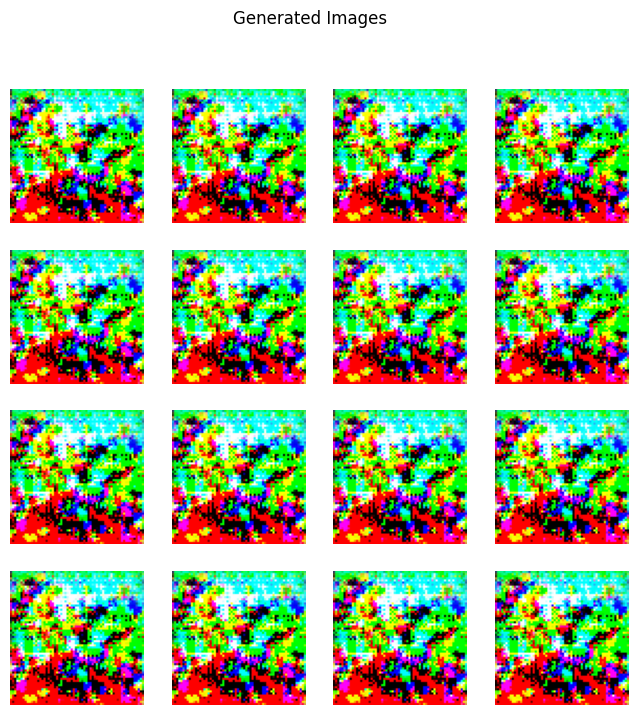

In [7]:
import matplotlib.pyplot as plt

# Generate some fake images for visualization
num_images_to_show = 16
z_sample = torch.randn(num_images_to_show, gen.latent_dim).to(device)
with torch.no_grad():
    generated_images = gen(z_sample).cpu()

# Plot the generated images
fig = plt.figure(figsize=(8, 8))
for i in range(num_images_to_show):
    ax = fig.add_subplot(4, 4, i + 1)
    img = generated_images[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis('off')
plt.suptitle("Generated Images")
plt.show()